<a href="https://colab.research.google.com/github/yingzibu/PBPK/blob/main/f2_bootstrap_continued.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Paper: Shah et al. In vitro dissolution profile comparison -- statistics and analysis of the similarity factor, f2

### f1 calculation
\begin{equation}
    f_1 = \frac{\sum_{t=1}^n |R_t - T_t|}{\sum_{t=1}^n R_t} \times 100
\end{equation}




### f2 calculation

The similarity factor ($f_2$) is a logarithmic reciprocal square root transformation of the sum of squared error and is a measurement of the similarity in the percent (%) dissolution between the two curves

\begin{equation}
f_2 = 50  \log \left\{ [1 + \frac{1}{n} \sum_{t=1}^n (R_t - T_t)^2]^{-0.5} \times 100
 \right\}
\end{equation}

In [87]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def cal_f1(R:list, T:list, ver=False):
    assert len(R) == len(T)
    sum_diff = 0
    sum_R = 0
    for i, j in zip(R, T):
        diff = np.abs(i-j)
        sum_diff += diff
        sum_R += i
    f1 = sum_diff / sum_R * 100
    if ver: print(f'F1 calculated for Reference and Test: {f1:.3f}')
    return f1

def cal_f2(R, T, ver=False):
    if type(R) == type(T) and type(R) == pd.DataFrame: # allows input type: pd.DataFrame
        R = list(R.mean(axis=0))
        T = list(T.mean(axis=0))
    assert type(R) == type(T) and type(R) == list # allows input type: list
    assert len(R) == len(T)
    num_here = len(R)
    sum_diff_square = 0
    for i, j in zip(R, T):
        temp = (i - j) ** 2
        sum_diff_square += temp
    f2 = sum_diff_square / num_here + 1
    f2 = f2 ** (-0.5) * 100
    f2 = 50 * np.log10(f2) # BE careful, np.log is ln, np.log10 is used here
    if ver: print(f'F2 calculated for Reference and Test: {f2:.3f}')
    return f2

In [21]:
def f2_from_diff(diff_in_percent):
    f2_limit = (1 + diff_in_percent**2)**(-0.5)*100
    f2_limit = 50 * np.log10(f2_limit)
    return f2_limit

f2_limits = []
diffs = [2, 5, 10, 15, 20]
for diff in diffs:
    f2_limit = f2_from_diff(diff)
    f2_limits.append(f2_limit)
columns = [f'{i}%' for i in diffs]
df_limit = pd.DataFrame.from_dict({'f2 limit': f2_limits},
                       orient='index', columns=columns)
print('Table 1. Average difference between two dissolution profiles of reference batches')
df_limit
# data = {'row_1': [3, 2, 1, 0], 'row_2': ['a', 'b', 'c', 'd']}
# pd.DataFrame.from_dict(data, orient='index',
#                        columns=['A', 'B', 'C', 'D'])


Table 1. Average difference between two dissolution profiles of reference batches


,2%,5%,10%,15%,20%
f2 limit,82.52575,64.625666,49.891966,41.147289,34.921391


In [22]:
# Table 2. Example #1. Dissolution profile of one reference and four test batches
t = [15, 30, 45, 60, 75, 90] # time in minutes
r = [40, 67, 80, 87, 89, 91] # reference
t1= [28, 51, 71, 88, 92, 94] # test batch 1
t2= [36, 69, 84, 89, 93, 95] # test batch 2
t3= [43, 78, 86, 93, 94, 96] # test batch 3
t4= [78, 89, 91, 93, 95, 98]
data_table_2 = {}
data_table_2['Reference'] = r
data_table_2['test batch # 1'] = t1
data_table_2['test batch # 2'] = t2
data_table_2['test batch # 3'] = t3
data_table_2['test batch # 4'] = t4
col_names = [f'{i} min' for i in t]
print('Table 2. Example #1: Dissolution profile of one reference and four test batches')
pd.DataFrame.from_dict(data_table_2, orient='index', columns=col_names)

Table 2. Example #1: Dissolution profile of one reference and four test batches


,15 min,30 min,45 min,60 min,75 min,90 min
Reference,40,67,80,87,89,91
test batch # 1,28,51,71,88,92,94
test batch # 2,36,69,84,89,93,95
test batch # 3,43,78,86,93,94,96
test batch # 4,78,89,91,93,95,98


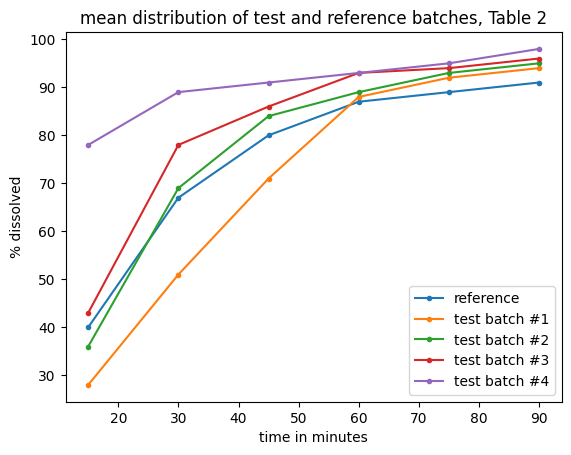

In [23]:
import matplotlib.pyplot as plt
plt.plot(t, r, '.-', label='reference')
plt.plot(t, t1,'.-', label='test batch #1')
plt.plot(t, t2,'.-', label='test batch #2')
plt.plot(t, t3,'.-', label='test batch #3')
plt.plot(t, t4,'.-', label='test batch #4')

plt.xlabel('time in minutes'); plt.ylabel('% dissolved')
# plt.xlim([0, max(t)*1.1])
# plt.ylim([0,100])
plt.title('mean distribution of test and reference batches, Table 2')
plt.legend(); plt.show(); plt.close()

In [24]:
f2_all, f2_till_60 = [], []
for idx, t in enumerate([t1, t2, t3, t4]):
    col_name = f'batch {idx}'
    f2 = cal_f2(r, t)
    f2_ = cal_f2(r[:4], t[:4])
    f2_all.append(f2)
    f2_till_60.append(f2_)
columns = [f'test batch {i}' for i in range(1,5)]
data_here = {'When calculated up to 60 minutes only': f2_till_60,
             'When calculated up to 90 minutes': f2_all}
df_here = pd.DataFrame.from_dict(data_here, orient='index', columns=columns)
print('Table 3:')
df_here

Table 3:


,test batch 1,test batch 2,test batch 3,test batch 4
When calculated up to 60 minutes only,47.885593,73.965183,57.204819,32.053039
When calculated up to 90 minutes,51.850018,72.151416,59.163289,36.012309


### F. Bias correction

The estimation bias is contributed by the term $\sum_{i=1}^P \frac{\sigma_{ti}^2 + \sigma_{ri}^2}{n}$ within the log function. An intuitive bias correction would lead to subtracting the unbiased estimate of $\sum_{i=1}^P \frac{\sigma_{ti}^2 + \sigma_{ri}^2}{n}$ within f$_2$ and we have the following unbiased estimate

\begin{align}
\hat{f_2}^* &= 50 \log_{10} \frac{100}{\sqrt{1 + \frac{1}{P} \left[\sum_{i=1}^P  (\overline{x_{ti}} - \overline{x_{ri}} )^2 - \sum_{i=1}^P \frac{s^2_{ti}+s^2_{ri}}{n}    \right]}} \\
&= 100 - 25 \log_{10} \left\{1 + \frac{1}{P} \left[\sum_{i=1}^P  (\overline{x_{ti}} - \overline{x_{ri}} )^2 - \sum_{i=1}^P \frac{s^2_{ti}+s^2_{ri}}{n} \right] \right\}
\end{align}


where $s^2_{ti}$ and $s^2_{ri}$ are the unbiased estimates of variance at the $i-$th time point of the test and reference batches respectively. The confidence interval is then adjusted accordingly. For the five test batches in example #2 the bias adjusted estimates are given in Table 7. It is shown in Table 7 that for the five comparisons, the bias adjusted estimates of f$_2$ are not much different to the biased estimate $\hat{f_2}$ because of the small dissolution variance of the six (one reference and five test) batches.

However, **the adjustment is not valid when** $\sum_{i=1}^P  (\overline{x_{ti}} - \overline{x_{ri}} )^2 < \sum_{i=1}^P \frac{s^2_{ti}+s^2_{ri}}{n}$

### Table 4

In [25]:
ref_df = pd.DataFrame()
ref_df[30] = [36.1,33,35.7,32.1,36.1,34.1,32.4,39.6,34.5,38,32.2,35.2]
ref_df[60] = [58.6,59.5,62.3,62.3,53.6,63.2,61.3,61.8,58,59.2,56.2,58]
ref_df[90] = [80,80.8,83,81.3,72.6,83,80,80.4,76.9,79.3,77.2,76.7]
ref_df[180]= [93.3,95.7,97.1,92.8,88.8,97.4,96.8,98.6,93.3,94,96.3,96.8]
print('Reference batch    mean')
for col in ref_df.columns:
    print(f'{col} min: \t  {np.mean(ref_df[col]):.2f}')
ref_df

Reference batch    mean
30 min: 	  34.92
60 min: 	  59.50
90 min: 	  79.27
180 min: 	  95.07


,30,60,90,180
0,36.1,58.6,80.0,93.3
1,33.0,59.5,80.8,95.7
2,35.7,62.3,83.0,97.1
3,32.1,62.3,81.3,92.8
4,36.1,53.6,72.6,88.8
5,34.1,63.2,83.0,97.4
6,32.4,61.3,80.0,96.8
7,39.6,61.8,80.4,98.6
8,34.5,58.0,76.9,93.3
9,38.0,59.2,79.3,94.0


In [26]:
test_df_1 = pd.DataFrame()
test_df_1[30] = [38.75,36.16,38.49,37.27,48.12,48.45,41.08,39.64,36.06,36.69,39.95,43.41]
test_df_1[60] = [61.79,61.21,63.89,62.52,77.18,80.62,67.62,63.68,61.59,63.6,67.98,74.07]
test_df_1[90] = [85.14,84.25,84.94,85.65,95.32,95.05,84.94,80.73,82.22,84.5,87.4,93.95]
test_df_1[180]= [100.2,97.3,96.39,95.47,99.3,98.94,99.03,95.63,96.12,98.42,98.1,97.8]
print('Test batch 1      mean')
for col in test_df_1.columns:
    print(f'{col} min: \t {np.mean(test_df_1[col]):.2f}')

test_df_1

Test batch 1      mean
30 min: 	 40.34
60 min: 	 67.15
90 min: 	 87.01
180 min: 	 97.72


,30,60,90,180
0,38.75,61.79,85.14,100.20
1,36.16,61.21,84.25,97.30
2,38.49,63.89,84.94,96.39
3,37.27,62.52,85.65,95.47
4,48.12,77.18,95.32,99.30
5,48.45,80.62,95.05,98.94
6,41.08,67.62,84.94,99.03
7,39.64,63.68,80.73,95.63
8,36.06,61.59,82.22,96.12
9,36.69,63.60,84.50,98.42


In [27]:
test_df_2 = pd.DataFrame()
test_df_2[30] = [48,52,48,53,45,48,51,49,44,53,49,52]
test_df_2[60] = [60,75,60,70,60,66,71,63,60,68,63,68]
test_df_2[90] = [84,89,83,93,84,90,91,89,84,81,86,87]
test_df_2[180]= [103,99,101,103,105,103,100,104,103,104,105,104]
print('Test batch 2      mean')
for col in test_df_2.columns:
    print(f'{col} min: \t {np.mean(test_df_2[col]):.2f}')

test_df_2

Test batch 2      mean
30 min: 	 49.33
60 min: 	 65.33
90 min: 	 86.75
180 min: 	 102.83


,30,60,90,180
0,48,60,84,103
1,52,75,89,99
2,48,60,83,101
3,53,70,93,103
4,45,60,84,105
5,48,66,90,103
6,51,71,91,100
7,49,63,89,104
8,44,60,84,103
9,53,68,81,104


In [28]:
test_df_3 = pd.DataFrame()
test_df_3[30] = [28.7,26.4,25.4,23.2,25.1,28.7,23.5,26.2,25,24.9,30.4,22]
test_df_3[60] = [48.2,53.1,52.4,49.5,50.7,54.1,50.3,50.6,49.1,49.5,53.9,46.3]
test_df_3[90] = [63.8,68.3,70,65.5,68,70.8,66.1,67.7,63.6,66.7,70.4,63]
test_df_3[180]= [85.6,90.6,89.5,92.2,87.6,93.6,85.1,88,85.8,86.6,89.9,88.7]
print('Test batch 3      mean')
for col in test_df_3.columns:
    print(f'{col} min: \t {np.mean(test_df_3[col]):.2f}')

test_df_3

Test batch 3      mean
30 min: 	 25.79
60 min: 	 50.64
90 min: 	 66.99
180 min: 	 88.60


,30,60,90,180
0,28.7,48.2,63.8,85.6
1,26.4,53.1,68.3,90.6
2,25.4,52.4,70.0,89.5
3,23.2,49.5,65.5,92.2
4,25.1,50.7,68.0,87.6
5,28.7,54.1,70.8,93.6
6,23.5,50.3,66.1,85.1
7,26.2,50.6,67.7,88.0
8,25.0,49.1,63.6,85.8
9,24.9,49.5,66.7,86.6


In [29]:
test_df_4 = pd.DataFrame()
test_df_4[30] = [17.1,16,12.7,15.1,14.1,12.1,14.4,19.6,14.5,14,18.2,13.2]
test_df_4[60] = [58.6,59.5,62.3,62.3,53.6,63.2,61.3,61.8,58,59.2,56.2,58]
test_df_4[90] = [80,80.8,83,81.3,72.6,83,80,80.4,76.9,79.3,77.2,76.7]
test_df_4[180]= [93.3,95.7,97.1,92.8,88.8,97.4,96.8,98.6,93.3,94,96.3,96.8]
print('Test batch 4      mean')
for col in test_df_4.columns:
    print(f'{col} min: \t {np.mean(test_df_4[col]):.2f}')

test_df_4

Test batch 4      mean
30 min: 	 15.08
60 min: 	 59.50
90 min: 	 79.27
180 min: 	 95.07


,30,60,90,180
0,17.1,58.6,80.0,93.3
1,16.0,59.5,80.8,95.7
2,12.7,62.3,83.0,97.1
3,15.1,62.3,81.3,92.8
4,14.1,53.6,72.6,88.8
5,12.1,63.2,83.0,97.4
6,14.4,61.3,80.0,96.8
7,19.6,61.8,80.4,98.6
8,14.5,58.0,76.9,93.3
9,14.0,59.2,79.3,94.0


In [30]:
test_df_5 = pd.DataFrame()
test_df_5[30] = [41.5,43.7,46.3,44,42.6,44.4,43,44.4,44.8,41.7,42.3,42]
test_df_5[60] = [78,78.3,78.3,79.9,73.2,78.4,79,79.6,78.7,76.9,77,78.2]
test_df_5[90] = [86.4,85.9,86.9,88.6,81.4,86.2,87.5,87.3,86.9,84.5,81.9,92.4]
test_df_5[180]= [98.3,102.9,96.4,96,95.5,98.4,99.5,99.9,97.8,100,97.9,100.3]
print('Test batch 5      mean')
for col in test_df_5.columns:
    print(f'{col} min: \t {np.mean(test_df_5[col]):.2f}')

test_df_5

Test batch 5      mean
30 min: 	 43.39
60 min: 	 77.96
90 min: 	 86.33
180 min: 	 98.58


,30,60,90,180
0,41.5,78.0,86.4,98.3
1,43.7,78.3,85.9,102.9
2,46.3,78.3,86.9,96.4
3,44.0,79.9,88.6,96.0
4,42.6,73.2,81.4,95.5
5,44.4,78.4,86.2,98.4
6,43.0,79.0,87.5,99.5
7,44.4,79.6,87.3,99.9
8,44.8,78.7,86.9,97.8
9,41.7,76.9,84.5,100.0


In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('*'*20, 'Table 5. Covariance matrices of the six batches', '*'*20)
for idx, df in enumerate([ref_df, test_df_1, test_df_2,
                          test_df_3, test_df_4, test_df_5]):
    if idx == 0: name_here = 'reference'
    else: name_here = f'test {idx}'
    print(name_here)
    print('--> standard deviation:\n', np.std(df, ddof=1))
    print('--> covariance:\n', df.cov())
    print('\n')

******************** Table 5. Covariance matrices of the six batches ********************
reference
--> standard deviation:
 30     2.356744
60     2.844452
90     2.979119
180    2.726678
dtype: float64
--> covariance:
           30        60        90        180
30   5.554242 -0.207273 -0.579394  0.193182
60  -0.207273  8.090909  7.888182  4.917273
90  -0.579394  7.888182  8.875152  5.051818
180  0.193182  4.917273  5.051818  7.434773


test 1
--> standard deviation:
 30     4.278954
60     6.622774
90     4.974753
180    1.550006
dtype: float64
--> covariance:
            30         60         90        180
30   18.309445  27.393051  18.731961  3.289986
60   27.393051  43.861136  30.529152  4.671305
90   18.731961  30.529152  24.748166  3.845214
180   3.289986   4.671305   3.845214  2.402518


test 2
--> standard deviation:
 30     2.964436
60     5.104959
90     3.671141
180    1.898963
dtype: float64
--> covariance:
            30         60         90        180
30    8.787879  1

### Table 7 Bias adjusted estimate of f2, calculated from scratch

In [32]:
def cal_f2_from_df(test_df, ref_df, bc=False, vc=False, ver=False): # implement bias corrected
    ref_mean = list(ref_df.mean(axis=0))
    test_mean = list(test_df.mean(axis=0))
    ref_S = [i**2 for i in np.std(ref_df, ddof=1).tolist()]
    test_S= [i**2 for i in np.std(test_df, ddof=1).tolist()]
    if vc: # apply variance-corrected f2
        bc = True
        sum_variance = 0
        for rs, ts in zip(ref_S, test_S):
            sum_s = rs + ts
            w_t = 0.5 + ts / sum_s
            w_r = 0.5 + rs / sum_s
            sum_variance += w_t * ts + w_r * rs
    else:
        sum_variance =  np.sum(ref_S) + np.sum(test_S)
    n = len(ref_df)   # number of units
    sum_variance /= n
    try: assert len(ref_df) == len(test_df)
    except: print('Different unit number between ref and test'); return
    P = len(ref_mean) # number of time points
    assert len(ref_mean) == len(test_mean)
    sum_diff_square = 0
    for i, j in zip(ref_mean, test_mean):
        sum_diff_square += (i-j) ** 2

    if bc: D = sum_diff_square - sum_variance
    else: D = sum_diff_square
    f2 = 100 - 25 * np.log10(1+D/P)
    if ver: return f2, sum_variance, sum_diff_square
    else: return f2


# Table 7
# Calculate from raw data
data_table_7 = {}
col_names = ['f2', 'sum(S_t^2 + S_i^2)/12', 'sum(X_t - X_r)^2', 'f2 *', 'f2 vcbc']
for idx, df in enumerate([test_df_1, test_df_2,
                          test_df_3, test_df_4, test_df_5]):
    f2, sum_var, sum_diff = cal_f2_from_df(df, ref_df, bc=False, ver=True)
    f2_star = cal_f2_from_df(df, ref_df, bc=True, ver=False)
    f2_vc = cal_f2_from_df(df, ref_df, bc=True, vc=True, ver=False)
    data_table_7[f'testing batch {idx+1}'] = [f2, sum_var, sum_diff, f2_star,f2_vc]


print('Table 7, calculated from scratch:')
print('Also calculated f2 vcbc: variance- and bias-corrected f2')
pd.DataFrame.from_dict(data_table_7, orient='index', columns=col_names)

Table 7, calculated from scratch:
Also calculated f2 vcbc: variance- and bias-corrected f2


,f2,sum(S_t^2 + S_i^2)/12,sum(X_t - X_r)^2,f2 *,f2 vcbc
testing batch 1,60.029877,9.939695,154.805274,60.731642,60.858539
testing batch 2,51.081984,6.823908,358.060069,51.288571,51.304449
testing batch 3,51.194210,4.668737,354.336944,51.336599,51.337441
testing batch 4,50.071866,4.954634,393.361111,50.208096,50.208118
testing batch 5,48.052052,3.990979,474.605764,48.142968,48.147397


### Table 7, calculate using author's data

Use data in column $\sum(S_t^2 + S_i^2)/12$ and $\sum(X_t - X_r)^2$ to calculate f2 and f2* (bias corrected)

In [33]:
# Table 7
# Calculate using data from Table 7
P = 4 # there are 4 time points
sum_Ss = [9.94, 6.82, 4.67, 4.95, 3.99]
sum_Xs = [154.81, 358.96, 354.34, 393.36, 474.61]
f2s = [60.03, 51.08, 51.19, 50.07, 48.05]

def f2_(sum_X, P=4):
    return 100 - 25 * np.log10(1 + sum_X / P)

def baf2_(sum_X, sum_S, P = 4):
    D = sum_X - sum_S
    return f2_(D, P = P)

data_table_7 = {}
col_names = ['f2', 'sum(S_t^2 + S_i^2)/12', 'sum(X_t - X_r)^2', 'f2*']
for idx, (x, s) in enumerate(zip(sum_Xs, sum_Ss)):
    f2 = f2_(x)
    f2_star = baf2_(x, s)
    data_table_7[f'testing batch {idx+1}'] = [f2, s, x, f2_star]
print('Table 7, calculated using author already calculated data: ')
pd.DataFrame.from_dict(data_table_7, orient='index', columns=col_names)

Table 7, calculated using author already calculated data: 


,f2,sum(S_t^2 + S_i^2)/12,sum(X_t - X_r)^2,f2*
testing batch 1,60.029554,9.94,154.81,60.731320
testing batch 2,51.055031,6.82,358.96,51.260981
testing batch 3,51.194118,4.67,354.34,51.336544
testing batch 4,50.071896,4.95,393.36,50.207998
testing batch 5,48.051956,3.99,474.61,48.142849


### Table 6

Bootstrap B times, sort the f2 based on its value,

#### The Normal interval

$\hat{f}_{2,L,U} = \hat{f}_{2,S} - \mathbb{E}_B \mp \sqrt{\mathbb{V}_B} \cdot Z_{1-\alpha}$


$\mathbb{E}_B = \frac{1}{B} \sum_{b=1}^B \hat{f}_{2,b}^* - \hat{f}_{2,S} = \overline{f}_2^* - \hat{f}_{2,S}$

$\mathbb{V}_B = \frac{1}{B-1} \sum_{b=1}^B (\hat{f}_{2,b}^* - \hat{f}_2^*)^2$

where $B$ is the number of bootstrap samples, $\hat{f}_{2,b}^*$ is the f2 estimate with $b$th bootstrap sample, and $\overline{f}_2^*$ is the mean value

In [ ]:
from scipy.stats import norm

B = 100
alpha_ = 0.05 # 90% confidence interval
bias_corrected = False
variance_corrected = False
repeat_times = 5

result_dict = {}

for B in [100, 200, 400, 500, 1000]:
    print('*'*70)
    print('*'*30, B, ' bootstraps', '*'*30)
    print('*'*70)
    df_B = pd.DataFrame()
    # result_df_list = []

    for num_here, test_df in enumerate([test_df_1, test_df_2, test_df_3,
                                        test_df_4, test_df_5]):

        test_batch_num = num_here + 1

        n = len(ref_df)

        f2_orig = cal_f2_from_df(test_df, ref_df, bc=bias_corrected,
                                vc=variance_corrected, ver=False)
        result_here = {}

        for repeat_time in range(repeat_times):
            # for i in tqdm(range(B), total=B, desc=f'Sample {B} times'):
            f2_estimates = []
            for i in range(B):
                r = ref_df.sample(n=n, replace=True) # resample with replacement
                t = test_df.sample(n=n, replace=True)
                f2 = cal_f2_from_df(t, r, bc=bias_corrected,
                                    vc=variance_corrected, ver=False)
                f2_estimates.append(f2)
            f2_estimates.sort()
            assert len(f2_estimates) == B
            f2_bootstrap_mean = np.mean(f2_estimates)
            E_B = f2_bootstrap_mean - f2_orig
            V_B = 0
            for f in f2_estimates:
                V_B += (f - f2_bootstrap_mean) ** 2
            V_B /= (B - 1)

            Z_95 = norm.ppf(1- alpha_)
            temp_ = np.sqrt(V_B) * Z_95
            f2_1 = f2_orig - E_B * temp_
            f2_2 = f2_orig + E_B * temp_
            f2_L = min(f2_1, f2_2); f2_U = max(f2_1, f2_2)
            result_here[f'Test batch {test_batch_num}, run {repeat_time + 1}'] = \
                                            [f2_orig, f2_bootstrap_mean, f2_L, f2_U]


        print('\n')
        print(f'Bootstrap sample {B}: Test batch {test_batch_num} run {repeat_times} times')
        cols_here = ['sample mean', f'{B} bootstraps mean', 'CI L', 'CL_U']
        result_df = pd.DataFrame.from_dict(result_here, orient='index', columns=cols_here)
        df = result_df.mean().to_frame()
        df = df.rename(columns={df.columns[0]: f'Test batch {test_batch_num}, mean'}).T
        result_df = pd.concat([result_df, df])
        print(result_df)
        print('\n')
        # result_df_list.append(result_df)
        df_B = pd.concat([df_B, df])

    result_dict[B] = df_B

**********************************************************************
****************************** 100  bootstraps ******************************
**********************************************************************


Bootstrap sample 100: Test batch 1 run 5 times
                     sample mean  100 bootstraps mean       CI L       CL_U
Test batch 1, run 1    60.029877            60.516198  56.128053  63.931700
Test batch 1, run 2    60.029877            60.225798  58.389419  61.670335
Test batch 1, run 3    60.029877            59.739890  57.812230  62.247523
Test batch 1, run 4    60.029877            59.955946  59.479977  60.579777
Test batch 1, run 5    60.029877            60.080847  59.677475  60.382279
Test batch 1, mean     60.029877            60.103736  58.297431  61.762323




Bootstrap sample 100: Test batch 2 run 5 times
                     sample mean  100 bootstraps mean       CI L       CL_U
Test batch 2, run 1    51.081984            51.011695  50.881738  51.282

In [ ]:
for k, v in result_dict.items():
    print(f'\nBootstrap {k} \n')
    print(v)


Bootstrap 100 

                    sample mean  100 bootstraps mean       CI L       CL_U
Test batch 1, mean    60.029877            60.103736  58.297431  61.762323
Test batch 2, mean    51.081984            51.055897  50.717947  51.446021
Test batch 3, mean    51.194210            51.140193  50.669154  51.719266
Test batch 4, mean    50.071866            50.004750  49.895149  50.248582
Test batch 5, mean    48.052052            48.010052  47.923597  48.180507

Bootstrap 200 

                    sample mean  200 bootstraps mean       CI L       CL_U
Test batch 1, mean    60.029877            60.359271  57.361262  62.698492
Test batch 2, mean    51.081984            50.959362  50.739420  51.424548
Test batch 3, mean    51.194210            51.207636  50.953171  51.435250
Test batch 4, mean    50.071866            49.971320  49.906468  50.237264
Test batch 5, mean    48.052052            47.949671  47.841457  48.262646

Bootstrap 400 

                    sample mean  400 bootstraps m

In [ ]:
df_B

,sample mean,1000 bootstraps mean,CI L,CL_U
"Test batch 1, mean",60.029877,60.279035,56.777958,63.281795
"Test batch 2, mean",51.081984,51.004742,50.734237,51.429731
"Test batch 3, mean",51.194210,51.267261,50.829985,51.558435
"Test batch 4, mean",50.071866,49.988361,49.848334,50.295397
"Test batch 5, mean",48.052052,47.996550,47.863962,48.240141



#### The basic interval:

and select the $(B+1)(1-\alpha)$th and $(B+1)\alpha$th f2 to calculate the interval.

If $(B+1)\alpha$ is not an integer, need interpolation:

$\hat{f}_{2,(B+1)\alpha}^* = \hat{f}^*_{2,k} + \frac{\phi^{-1}(\alpha) - \phi^{-1} (\frac{k}{B+1})}{\phi^{-1}(\frac{k+1}{B+1}) - \phi^{-1}(\frac{k}{B+1})} \left(\hat{f}^*_{2,k+1} - \hat{f}^*_{2,k}  \right)$

where $k$ is the interger part of $(B+1)\alpha$. To avoid the burden, let B + 1 could be divided by 100 and $\alpha = 0.05$ thus we could avoid this burden.

In [34]:
B = 99
alpha_ = 0.05 # 90% confidence interval
f2_estimates = []
n = len(ref_df)
test_df = test_df_1

bias_corrected = False
variance_corrected = False

f2_orig = cal_f2_from_df(test_df, ref_df, bc=bias_corrected,
                         vc=variance_corrected, ver=False)
for i in tqdm(range(B), total=B, desc=f'Sample {B} times'):
    r = ref_df.sample(n=n, replace=True) # resample with replacement
    t = test_df.sample(n=n, replace=True)
    f2 = cal_f2_from_df(t, r, bc=bias_corrected, vc=variance_corrected, ver=False)
    f2_estimates.append(f2)
f2_estimates.sort()
print('The basic interval: ')
idx_1 = (B + 1) * alpha_ - 1
idx_2 = (B + 1) * (1 - alpha_) - 1
assert int(idx_1) - idx_1 == 0  # make sure that idx_1 is integer
assert int(idx_2) - idx_2 == 0  # make sure that idx_2 is integer
idx_1 = int(idx_1); idx_2 = int(idx_2)
f2_U = 2 * f2_orig - f2_estimates[idx_1]
f2_L = 2 * f2_orig - f2_estimates[idx_2]
print('\n\nf2, f2_L, f2_U, mean of bootstrap f2: ')
f2_orig, f2_L, f2_U, np.mean(f2_estimates)

Sample 99 times: 100%|██████████| 99/99 [00:00<00:00, 339.38it/s]


The basic interval: 


f2, f2_L, f2_U, mean of bootstrap f2: 


(60.02987672579619, 51.66945969710572, 67.07248910363212, 60.225717577454525)

### jackknife technique to calculate bias-corrected and accelerated (BCa) intervals

`from scipy.stats import norm`

$\phi$:
`norm.cdf(num)`

$\phi^{-1}$:
`norm.ppf(num)`

In [35]:
from scipy.stats import norm

norm.ppf(0.95),norm.cdf(norm.ppf(0.95))

(1.6448536269514722, 0.95)

In [92]:
B = 1000

def bootstrap_f2_list(test_df, ref_df, B=100, bc=False, vc=False, ver=False):
    n = len(ref_df)
    f2_orig = cal_f2_from_df(test_df, ref_df, bc=bc, vc=vc, ver=ver)
    f2_estimates = []
    for i in range(B):
        r = ref_df.sample(n=n, replace=True) # resample with replacement
        t = test_df.sample(n=n, replace=True)
        f2 = cal_f2_from_df(t,r, bc=bc, vc=vc, ver=ver)
        f2_estimates.append(f2)
    f2_estimates.sort()
    assert len(f2_estimates) == B
    return f2_estimates


bootstrap_f2_list(ref_df, t, B=10)

[64.6126152265868,
 64.97528750355002,
 66.71899636819259,
 66.73205568947017,
 69.95984410939647,
 70.3083367872014,
 70.6169131760218,
 75.67707420069765,
 78.02127092394298,
 78.20627369347434]

Jackknife statistic does not change with bootstrap as this is calculated using the original ref and test by omitting observations. From R reference bootf2:

"
For any sample with size $n$, the jackknife estimator is obtained by estimating the parameter for each subsample omitting the $i$th observation. When 2 samples (e.g. test and reference) are invovled, there are several possible ways to do it. Assuming sample size of test and reference are $n_T$ and $n_R$:

* Estimated by removing one observation from both test and reference samples. In this case, the prerequisite is $n_T == n_R$, denoted by `nt=nr` in the function. Will have $n_T$ jackknife estimators.

* Estimate the jackknife for test sample while keeping the reference data unchanged, and then estimate jackknife for reference sample while keeping the test sample unchanged. This is denoted by `nt+nr` in the function. **Dfault** method. Will have $n_T + n_R$ jackknife estimators.

* For each observation deleted from test sample, estimate jackkinfe for reference sample. This is denoted by `nt*nr` in the function. Will have $n_T * n_R$ jackknife estimators.


"

In [95]:
def jackknife_statistic(ref_df, test_df, type_jk='nt=nr'):
    nt = len(test_df)
    nr = len(ref_df)
    jk_list = []
    if type_jk == 'nt=nr':
        assert nt == nr
        for i in range(nt):
            t = test_df.drop(i)
            r = ref_df.drop(i)
            f2 = cal_f2(t, r)
            jk_list.append(f2)
    elif type_jk == 'nt+nr':
        for i in range(nt):
            t = test_df.drop(i)
            f2 = cal_f2(t, ref_df)
            jk_list.append(f2)

        for i in range(nr):
            r = ref_df.drop(i)
            f2 = cal_f2(test_df, r)
            jk_list.append(f2)
    elif type_jk == 'nt*nr':
        for i in range(nt):
            t = test_df.drop(i)
            for j in range(nr):
                r = ref_df.drop(j)
                f2 = cal_f2(t, r)
                jk_list.append(f2)

    else:
        print("""type_jk should be one of['nt+nr', 'nt*nr', 'nt=nr']""")
        return
    return jk_list

Using Jackknife technique to estimate $\hat{z_0}$ and $\hat{a}$

$$\hat{a} = \frac{\sum_{i=1}^n (\hat{f}_{2,m} - \hat{f}_{2,i})^3}{6\left( \sum_{i=1}^n (\hat{f}_{2,m} - \hat{f}_{2,i})^2   \right)^{3/2}}$$

$\hat{f}_{2,i}$ is the $i$th jackknife statistic, $\hat{f}_{2,m}$ is the mean of the jackknife statistics. Notice that $\hat{a}$ is calculated using jackknife, is not related to the bootstrap.


$$\hat{z_0} = \phi^{-1} \left(\frac{N\{\hat{f}^*_{2,b} < \hat{f}_{2,S}\}}{B}   \right)$$

where $N\{\cdot \}$ denotes the number of element in the set (number of bootstrap f2 smaller than f2). B is the bootstrap number.

$$\alpha_1 = \phi  \left(\hat{z_0} +\frac{\hat{z_0}+\hat{z_\alpha}}{1 - \hat{a}(\hat{z_0}+\hat{z_\alpha})}\right)$$

$$\alpha_2 = \phi  \left(\hat{z_0} +\frac{\hat{z_0}+\hat{z_{1-\alpha}}}{1 - \hat{a}(\hat{z_0}+\hat{z_{1-\alpha}})}\right)$$

Then the bias-corrected and accelerated (BCa) intervals are estimated according to Efron and Tibshirani,

$$\hat{f}_{2,L} = \hat{f}^*_{2, \alpha_1}$$

$$\hat{f}_{2,U} = \hat{f}^*_{2, \alpha_2}$$

where $\hat{f}^*_{2, \alpha_1}$ and $\hat{f}^*_{2, \alpha_2}$ are the 100$\alpha_1$ th and the $100 \alpha_2$ th percentile of the resampling estimates of f2, respectively.

In [110]:
def BCa_jk(jk_list, f2_estimates, alpha_=alpha_):
    m = np.mean(jk_list) # mean of the jackknife statistics
    u, d = 0, 0
    for i in jk_list:
        diff = m - i
        u += diff**3
        d += diff**2
    a_hat = u / (d**1.5)
    a_hat /= 6
    f2_num = sum(i < f2_orig for i in f2_estimates)
    z0_hat = norm.ppf(f2_num/len(f2_estimates))
    z_alpha = norm.ppf(alpha_)
    z_1_alpha = norm.ppf(1-alpha_)

    def cal_alpha(z_, z0_hat=z0_hat, a_hat=a_hat):
        temp = z0_hat + z_
        temp1 = temp / (1-a_hat*temp)
        temp1 += z0_hat
        return norm.cdf(temp1)

    alpha_1 = cal_alpha(z_alpha)
    alpha_2 = cal_alpha(z_1_alpha)
    f2_L = np.percentile(np.array(f2_estimates), 100*alpha_1)
    f2_U = np.percentile(np.array(f2_estimates), 100*alpha_2)
    return m, f2_L, f2_U



In [111]:
# jk_list does not change as bootstrap

for num_here, test_df in enumerate([test_df_1, test_df_2, test_df_3,
                                        test_df_4, test_df_5]):

    test_batch_num = num_here + 1
    jk_list = jackknife_statistic(ref_df, test_df, type_jk='nt=nr')
    f2_orig = cal_f2(test_df, ref_df)
    result_here = {}
    for B in [100, 200, 400, 500, 1000]:
        f2_estimates = bootstrap_f2_list(ref_df, test_df, B=B)
        bootstrap_mean = np.mean(f2_estimates)
        m, f2_L, f2_U = BCa_jk(jk_list, f2_estimates, alpha_=alpha_)
        f2_L_percent = np.percentile(np.array(f2_estimates), 100*alpha_)
        f2_U_percent = np.percentile(np.array(f2_estimates), 100*(1-alpha_))
        # print(m, f2_L, f2_U)
        result_here[f'Test batch {test_batch_num} '] = [f2_orig, bootstrap_mean,
                                                        f2_L_percent, f2_U_percent]

        result_here[f'Test batch {test_batch_num} BCa'] = [m, bootstrap_mean, f2_L, f2_U]
        cols_here = ['jackknife mean', f'{B} bootstraps mean', 'CI_L', 'CL_U']
        result_df = pd.DataFrame.from_dict(result_here, orient='index', columns=cols_here)
        print(result_df)
        print('\n')
    print('\n')

                  jackknife mean  100 bootstraps mean       CI_L       CL_U
Test batch 1           60.029877            60.167704  53.774084  67.091742
Test batch 1 BCa       60.079670            60.167704  54.145500  68.774386


                  jackknife mean  200 bootstraps mean       CI_L       CL_U
Test batch 1           60.029877            60.311732  52.913407  67.419718
Test batch 1 BCa       60.079670            60.311732  52.021772  66.350019


                  jackknife mean  400 bootstraps mean       CI_L       CL_U
Test batch 1           60.029877            60.259451  53.230231  68.470241
Test batch 1 BCa       60.079670            60.259451  52.908348  68.163837


                  jackknife mean  500 bootstraps mean       CI_L       CL_U
Test batch 1           60.029877            60.734079  53.295637  68.885484
Test batch 1 BCa       60.079670            60.734079  51.514031  67.812703


                  jackknife mean  1000 bootstraps mean       CI_L       CL_U
Tes

In [112]:
# jk_list does not change as bootstrap

for num_here, test_df in enumerate([test_df_1, test_df_2, test_df_3,
                                        test_df_4, test_df_5]):

    test_batch_num = num_here + 1
    jk_list = jackknife_statistic(ref_df, test_df, type_jk='nt=nr')
    f2_orig = cal_f2(test_df, ref_df)
    result_here = {}
    for B in [10000]:
        f2_estimates = bootstrap_f2_list(ref_df, test_df, B=B)
        bootstrap_mean = np.mean(f2_estimates)
        m, f2_L, f2_U = BCa_jk(jk_list, f2_estimates, alpha_=alpha_)
        f2_L_percent = np.percentile(np.array(f2_estimates), 100*alpha_)
        f2_U_percent = np.percentile(np.array(f2_estimates), 100*(1-alpha_))
        # print(m, f2_L, f2_U)
        result_here[f'Test batch {test_batch_num} '] = [f2_orig, bootstrap_mean,
                                                        f2_L_percent, f2_U_percent]

        result_here[f'Test batch {test_batch_num} BCa'] = [m, bootstrap_mean, f2_L, f2_U]
        cols_here = ['jackknife mean', f'{B} bootstraps mean', 'CI_L', 'CL_U']
        result_df = pd.DataFrame.from_dict(result_here, orient='index', columns=cols_here)
        print(result_df)
        print('\n')
    print('\n')

                  jackknife mean  10000 bootstraps mean       CI_L       CL_U
Test batch 1           60.029877               60.34452  53.104879  68.519667
Test batch 1 BCa       60.079670               60.34452  52.483764  67.679649




                  jackknife mean  10000 bootstraps mean       CI_L       CL_U
Test batch 2           51.081984              51.022556  48.273964  53.910863
Test batch 2 BCa       51.077515              51.022556  48.469825  54.113043




                  jackknife mean  10000 bootstraps mean       CI_L       CL_U
Test batch 3           51.194210              51.209866  48.328856  54.386825
Test batch 3 BCa       51.195338              51.209866  48.634207  54.915963




                  jackknife mean  10000 bootstraps mean       CI_L       CL_U
Test batch 4           50.071866              49.985388  48.389765  51.629057
Test batch 4 BCa       50.073624              49.985388  48.643350  51.878240




                  jackknife mean  10000 bootstra


Understandable since f1: smaller, better (0-15 cutoff); f2: larger, better (50-100 cutoff)